In [50]:
%load_ext autoreload
%autoreload 2

import re
import time
import json
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
%matplotlib inline
import spacy
from textblob import TextBlob
from wordcloud import WordCloud

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# Load data:
file_path = '../data/raw/complaints-2021-05-14_08_16_.json'
with open(file_path, 'r') as f:
    data = json.load(f) 
    df = pd.json_normalize(data)

df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [7]:
# Rename column names:
df.columns = [
    'index', 'type', 'id', 'score', 'tags', 'zip_code',
    'complaint_id', 'issue', 'date_received', 'state', 
    'consumer_disputed', 'product', 'company_response', 
    'company', 'submitted_via', 'date_sent_to_company', 
    'company_public_response', 'sub_product', 'timely',
    'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'
]

df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [8]:
# Check percentage of missing value
df.isna().sum() / len(df) * 100

index                         0.000000
type                          0.000000
id                            0.000000
score                         0.000000
tags                         86.081493
zip_code                      8.628197
complaint_id                  0.000000
issue                         0.000000
date_received                 0.000000
state                         2.542362
consumer_disputed             0.000000
product                       0.000000
company_response              0.000000
company                       0.000000
submitted_via                 0.000000
date_sent_to_company          0.000000
company_public_response      99.994892
sub_product                  13.498397
timely                        0.000000
complaint_what_happened       0.000000
sub_issue                    59.117899
consumer_consent_provided     1.287143
dtype: float64

In [9]:
# Handle missing values:
df['complaint_what_happened'] = df['complaint_what_happened'].replace('', np.nan)
print(f'DataFrame shape: {df.shape}')

# Drop based on empty values of customer complaints:
df = df.dropna(subset=['complaint_what_happened'])
df = df[['complaint_what_happened']].reset_index(drop=True)
print(f'DataFrame shape (after dropping NaN values): {df.shape}')

DataFrame shape: (78313, 22)
DataFrame shape (after dropping NaN values): (21072, 1)


In [26]:
# Functions
def normalize_text(text: str) -> str:
    """Normalize a text.
    
    Args:
        text (str): text.
    Returns:
        str: normalized text.
    """
    return text.lower()

def remove_punctuations(text) -> str:
    """Remove punctuations from a text.
    
    Args:
        text (str): text.
    Returns:
        str: text with removed punctuations.
    """
    return re.sub(r'[^\w\s]', '', text)

def remove_word_brackets(text) -> str:
    """Remove words in brackets from a text.
    
    Args:
        text (str): text.
    Returns:
        str: text with removed words in brackets.
    """
    return re.sub(r'\[.*?\]', '', text)

def remove_word_numbers(text) -> str:
    """Remove punctuations from a text.
    
    Args:
        text (str): text.
    Returns:
        str: text with removed punctuations.
    """
    return re.sub(r'\b\w*\d\w*\b', '', text)

def remove_confidential_information(text) -> str:
    """Remove confidential information from a text.
    
    Args:
        text (str): text.
    Returns:
        str: text with removed confidential information.
    """
    return  re.sub(r'x{1,}', '', text)

def remove_extra_spaces(text) -> str:
    """Remove extra spaces or new lines from a text.
    
    Args:
        text (str): text.
    Returns:
        str: text with removed extra spaces or new lines.
    """
    return re.sub(r'\s+', ' ', text)

def clean_text(text: str) -> str:
    """Clean text.
    
    Args:
        text (str): text.
    Returns:
        str: cleaned text.
    """
    text = normalize_text(text)
    text = remove_punctuations(text)
    text = remove_word_brackets(text)
    text = remove_word_numbers(text)
    text = remove_confidential_information(text)
    text = remove_extra_spaces(text)
    return text

# Text cleaning
df['cleaned_complaint_what_happened'] = df['complaint_what_happened'].apply(clean_text)

In [28]:
# Set display options to prevent truncation
pd.set_option('display.max_colwidth', None)  # Set None for no limit
pd.set_option('display.expand_frame_repr', False)  # Prevent wrapping to multiple lines

df.head()

,complaint_what_happened,cleaned_complaint_what_happened
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account thanks in advance for your help
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me
2,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not etend credit without verifying the identity of the applicant
3,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why. I asked for more information about the XXXX offer and she explained that even if I had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. I then explicitly told her I was glad I got denied and I was ABSOLUTELY no longer interested in the account. I asked that the application be withdrawn and the representative obliged. This all happened no later than 10mins after putting in the application on XX/XX/2018. Notwithstanding my explicit request not to proceed with the application and contrary to what I was told by the Chase representative, Chase did in fact go ahead to open a credit account in my name on XX/XX/2018. This is now being reported in my Credit Report and Chase has refused to correct this information on my credit report even though they went ahead to process an application which I did not consent to and out of their error.",on while trying to book a ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and

In [33]:
# # Run this this before the next cell
# !python -m spacy download en_core_web_sm

In [36]:
nlp = spacy.load('en_core_web_sm')

def lemma_texts(text):     
        
    # Initialize empty list to store lemmas
    lemma_list = []
    
    # Extract lemmas of given text and add to the list 'sent'
    document = nlp(text)
    for word in document:
        lemma_list.append(word.lemma_)
        
    # Return string converted form of the list of lemmas
    return " ".join(lemma_list)

# Apply lemmatization
df['lemmatized_complaint_what_happened'] = df['cleaned_complaint_what_happened'].apply(lemma_texts)

In [37]:
# Set display options to prevent truncation
pd.set_option('display.max_colwidth', None)  # Set None for no limit
pd.set_option('display.expand_frame_repr', False)  # Prevent wrapping to multiple lines

df.head()

,complaint_what_happened,cleaned_complaint_what_happened,lemmatized_complaint_what_happened
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account thanks in advance for your help,good morning my name be and I appreciate it if you could help I put a stop to chase bank cardmember service in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt I have a right to know this information as a consumer chase account thank in advance for your help
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me,I upgrade my card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account change my anniversary date from to without my consent have the recording of the agent who be mislead I
2,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not etend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not etend credit without verify the identity of the applicant
3,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why. I asked for more information about the XXXX offer and she explained that even if I had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. I then explicitly told her I was glad I got denied and I was ABSOLUTELY no longer interested in the account. I asked that the application be withdrawn and the representative o

In [52]:
# Extract nouns which leads us to the topic
def extract_singular_nouns(text):
    blob = TextBlob(text)
    return ' '.join([word for word, tag in blob.tags if tag=='NN'])

# Applying the function to create a new column containing only singular nouns 
df["complaint_POS_removed"] =  df['lemmatized_complaint_what_happened'].apply(extract_singular_nouns)

# View the dataframe
df.head()

,complaint_what_happened,cleaned_complaint_what_happened,lemmatized_complaint_what_happened,complaint_POS_removed
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account thanks in advance for your help,good morning my name be and I appreciate it if you could help I put a stop to chase bank cardmember service in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt I have a right to know this information as a consumer chase account thank in advance for your help,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me,I upgrade my card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account change my anniversary date from to without my consent have the recording of the agent who be mislead I,card agent upgrade date agent information order account change date consent recording agent
2,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not etend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not etend credit without verify the identity of the applicant,card report application identity consent service credit identity applicant
3,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why. I asked for more information about the XXXX

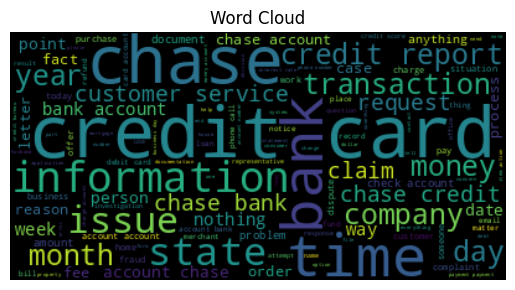

In [53]:
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(str(df["complaint_POS_removed"].tolist()))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word Cloud")
plt.axis("off")
plt.show()

# Topic Modelling

In [11]:
# Load texts
with open("../data/processed/cleaned_texts.txt", "r") as f:
    cleaned_texts = f.readlines()
    cleaned_texts = [text.strip().split() for text in cleaned_texts]

In [12]:
import gensim
from gensim.corpora import Dictionary

In [15]:
# Define the dictionary
dictionary = Dictionary(cleaned_texts)

# Define the corpus 
corpus = [dictionary.doc2bow(text) for text in cleaned_texts]

In [19]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=5)

# Save the topics and top 5 words
topics = ldamodel.print_topics(num_words=10)

# Print the results
for topic in topics:
    print(topic)

(0, '0.038*"chase" + 0.020*"loan" + 0.018*"payment" + 0.017*"mortgage" + 0.009*"bank" + 0.009*"request" + 0.008*"letter" + 0.008*"pay" + 0.008*"debt" + 0.007*"state"')
(1, '0.023*"chase" + 0.015*"would" + 0.014*"credit" + 0.013*"get" + 0.013*"year" + 0.011*"offer" + 0.011*"month" + 0.011*"time" + 0.010*"pay" + 0.009*"rate"')
(2, '0.075*"account" + 0.044*"chase" + 0.031*"payment" + 0.026*"bank" + 0.026*"check" + 0.021*"fee" + 0.018*"pay" + 0.018*"balance" + 0.014*"charge" + 0.014*"close"')
(3, '0.054*"credit" + 0.052*"card" + 0.045*"chase" + 0.026*"charge" + 0.019*"report" + 0.015*"dispute" + 0.012*"account" + 0.011*"receive" + 0.009*"information" + 0.008*"purchase"')
(4, '0.028*"call" + 0.027*"chase" + 0.018*"tell" + 0.018*"bank" + 0.017*"account" + 0.017*"say" + 0.014*"would" + 0.014*"money" + 0.013*"get" + 0.012*"go"')
